In [34]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [35]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [36]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Figure description

#### FIGURE 1 OF MAIN PAPER

- code and ncs for model evaluation (years 2013-2017 of hindcast201905) are in ./MODEL_EVAL_scripts
- ncmaker_hindcast201905.py is the script to make nc's that find model data corresponding to the Ianson GRL dataset, it calls picklr_forhindcast201905 - all scripts were rerun Mar 2020 to make these figures. 

##### To do list

- [] add annotations and, eg, fraser river
- [] add JdF/JS notes to thalweg

In [37]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seawater
import netCDF4 as nc
import skill_metrics as sm #https://github.com/PeterRochford/SkillMetrics/tree/master/skill_metrics
from mpl_toolkits.basemap import Basemap
import pickle
from cmocean import cm
from salishsea_tools import visualisations as vis
import arrow
import glob
from scipy.io import loadmat
%matplotlib inline

#### BASEMAP PLOTTING CODE

In [38]:
def plot_basemap(ax, w_map, lons=None, lats=None, offset=[None, None], zorder=[0, 1, 2]):
    """
    """
    
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='l',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.floor([w_map[0], w_map[1] + 1])
    if lats is None:
        lats = np.floor([w_map[2], w_map[3] + 1])
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    m.fillcontinents(color='Burlywood', zorder=zorder[0])
    m.drawmeridians(np.arange(*lons), labels=[0, 0, 1, 0], color='dimgray', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(np.arange(*lats), labels=[0, 1, 0, 0], color='dimgray', xoffset=offset[0], zorder=zorder[2])
    
    return m

def plot_thalweg(ax, T_lon, T_lat):
    lines = np.loadtxt('/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt', delimiter=" ", unpack=False)
    lines = lines.astype(int)

    thalweg_lon = T_lon[lines[:,0],lines[:,1]]
    thalweg_lat = T_lat[lines[:,0],lines[:,1]]
    ax.plot(thalweg_lon, thalweg_lat, 'r')

#### LOAD GRID AND PREVIOUSLY-CALCULATED QUANTITIES

In [39]:
#open bathymetry grid
grid = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
bathy = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
meshmask = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

BR3_DIC_winter = pickle.load(open('../pkls/BR3_DIC_winter_mean.pkl', 'rb'))  
BR3_DIC_summer = pickle.load(open('../pkls/BR3_DIC_summer_mean.pkl', 'rb'))  
BR3_sal_summer = pickle.load(open('../pkls/BR3_sal_summer_mean.pkl', 'rb')) 

#### LOAD OBSERVATIONAL DATA TO COMPARE AGAINST AND CALCULATE TAYLOR STATISTIC

In [40]:
#TJ load observational dataset - Ianson 2016
infil = np.loadtxt('./Datasets/grl2016_nu.txt')
P = infil[:,8]
T = infil[:,9]
S = infil[:,10]
dic = infil[:,13]
dens = seawater.dens(S,T,P)
# CONVERT FROM UMOL TO MMOL/M3
dic_conv=dic*dens/1000

#extracted model evaluation steps
scrdir = './MODEL_EVAL_scripts/'

DIC13 = nc.Dataset(scrdir+'/DIC_hindcast201905_GRL_comp_2013.nc')
DIC_mod13 = DIC13['model_output']['mod_point'][:]
DIC_mod13[DIC_mod13==0]=np.nan
dic_compbl = dic_conv[~(np.isnan(DIC_mod13))]
DIC_mod13_compbl = DIC_mod13[~(np.isnan(DIC_mod13))]

DIC14 = nc.Dataset(scrdir+'/DIC_hindcast201905_GRL_comp_2014.nc')
DIC_mod14 = DIC14['model_output']['mod_point'][:]
DIC_mod14[DIC_mod14==0]=np.nan
dic_compbl = dic_conv[~(np.isnan(DIC_mod14))]
DIC_mod14_compbl = DIC_mod14[~(np.isnan(DIC_mod14))]

DIC15 = nc.Dataset(scrdir+'/DIC_hindcast201905_GRL_comp_2015.nc')
DIC_mod15 = DIC15['model_output']['mod_point'][:]
DIC_mod15[DIC_mod15==0]=np.nan
dic_compbl = dic_conv[~(np.isnan(DIC_mod15))]
DIC_mod15_compbl = DIC_mod15[~(np.isnan(DIC_mod15))]

DIC16 = nc.Dataset(scrdir+'/DIC_hindcast201905_GRL_comp_2016.nc')
DIC_mod16 = DIC16['model_output']['mod_point'][:]
DIC_mod16[DIC_mod16==0]=np.nan
dic_compbl = dic_conv[~(np.isnan(DIC_mod16))]
DIC_mod16_compbl = DIC_mod16[~(np.isnan(DIC_mod16))]

DIC17 = nc.Dataset(scrdir+'/DIC_hindcast201905_GRL_comp_2017.nc')
DIC_mod17 = DIC17['model_output']['mod_point'][:]
DIC_mod17[DIC_mod17==0]=np.nan
dic_compbl = dic_conv[~(np.isnan(DIC_mod17))]
DIC_mod17_compbl = DIC_mod17[~(np.isnan(DIC_mod17))]

#calculate taylor statistics
taylor_statsDIC13 = sm.taylor_statistics(DIC_mod13_compbl[dic_compbl>1800],dic_compbl[dic_compbl>1800],'data')
taylor_statsDIC14 = sm.taylor_statistics(DIC_mod14_compbl[dic_compbl>1800],dic_compbl[dic_compbl>1800],'data')
taylor_statsDIC15 = sm.taylor_statistics(DIC_mod15_compbl[dic_compbl>1800],dic_compbl[dic_compbl>1800],'data')
taylor_statsDIC16 = sm.taylor_statistics(DIC_mod16_compbl[dic_compbl>1800],dic_compbl[dic_compbl>1800],'data')
taylor_statsDIC17 = sm.taylor_statistics(DIC_mod17_compbl[dic_compbl>1800],dic_compbl[dic_compbl>1800],'data')

## Store statistics in arrays
sdevDIC = np.array([taylor_statsDIC13['sdev'][0],
                 taylor_statsDIC13['sdev'][1],
                 taylor_statsDIC14['sdev'][1],
                 taylor_statsDIC15['sdev'][1],
                 taylor_statsDIC16['sdev'][1],
                 taylor_statsDIC17['sdev'][1]])

crmsdDIC = np.array([taylor_statsDIC13['crmsd'][0],
                 taylor_statsDIC13['crmsd'][1],
                 taylor_statsDIC14['crmsd'][1],
                 taylor_statsDIC15['crmsd'][1],
                 taylor_statsDIC16['crmsd'][1],
                 taylor_statsDIC17['crmsd'][1]])

ccoefDIC = np.array([taylor_statsDIC13['ccoef'][0],
                 taylor_statsDIC13['ccoef'][1],
                 taylor_statsDIC14['ccoef'][1],
                 taylor_statsDIC15['ccoef'][1],
                 taylor_statsDIC16['ccoef'][1],
                 taylor_statsDIC17['ccoef'][1]])

#code is using 'example 9' from the taylor diagram code
label = ['nonden_obs','2013', '2014','2015','2016','2017']


#### CODE FOR SUBPLOTS IN PYTHON

/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.


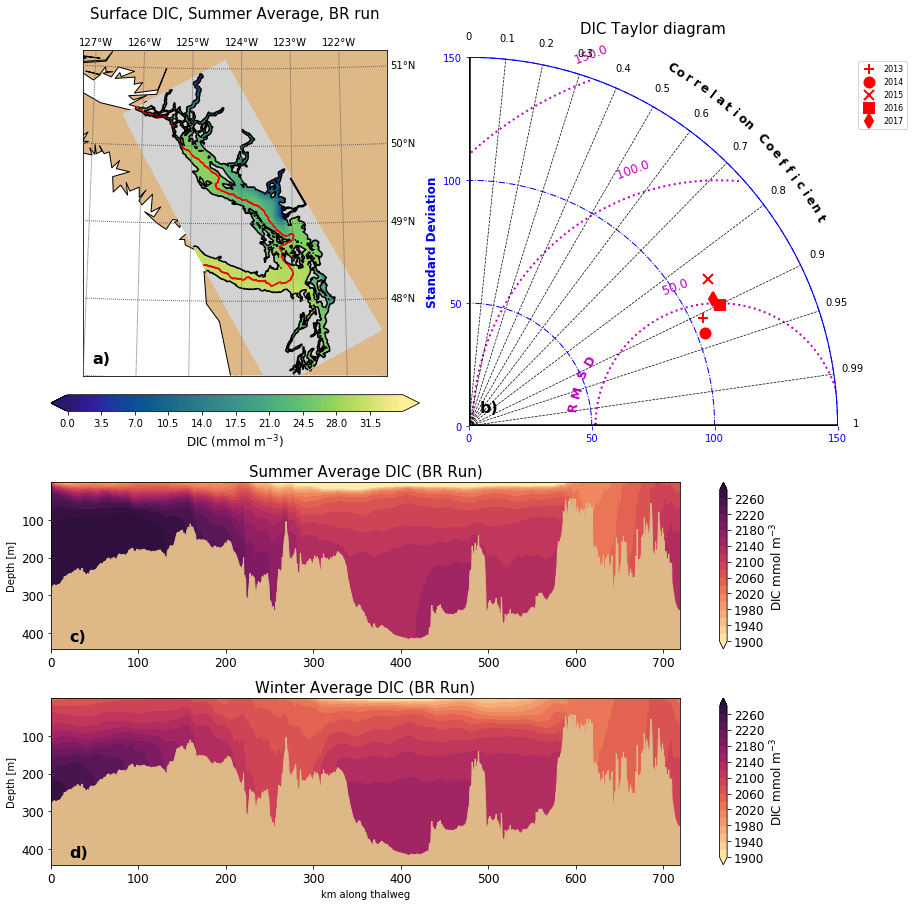

In [41]:
#set plot parameters
#scaling factor 
fact = 1.1
fs = 12
dicmin_twg = 1900
dicmax_twg = 2300
dicmin_surf = 0
dicmax_surf = 35
dicstep = 20
halstep = 0.1

fig = plt.figure(figsize=(11.5*fact, 11.5*fact))

#domain plot - BR run summer average
ax1 = plt.subplot2grid((8,8), (0,0), colspan=4, rowspan=4) 

w_map = [-127, -121, 47, 51.2]
m = plot_basemap(ax1, w_map, zorder=[0, 1, 7]) #offset=[-30000, -15000]
x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)  
#define data to plot as the surface level of the summer dataset
tdat_p = BR3_sal_summer[0,:,:]
mesh = ax1.contourf(x, y, tdat_p, levels=np.arange(dicmin_surf, dicmax_surf, halstep), \
                 cmap=cm.haline, extend = 'both') # extend='both', zorder=.2)

ax1.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
ax1.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)
plot_thalweg(ax1, x, y)
ax1.set_title('Surface DIC, Summer Average, BR run',fontsize = fs+3, y=1.08)

cbar = fig.colorbar(mesh, ax=ax1, orientation = 'horizontal',fraction=0.1, pad=0.05)
cbar.set_label(label='DIC (mmol m$^{-3}$)', size=fs)
ax1.text(0.03, 0.03, 'a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='bottom')


#taylor diagram of model evaluation
ax2 = plt.subplot2grid((8,8), (0,4), colspan=4, rowspan=4)
sm.taylor_diagram(sdevDIC,crmsdDIC,ccoefDIC, markerLabel = label,
                  markerLabelColor = 'r', 
                  markerColor = 'r', markerLegend = 'on', 
                  tickRMSangle = 110.0,
                  colRMS = 'm', styleRMS = ':', widthRMS = 2.0, 
                  titleRMS = 'on',  colSTD = 'b', styleSTD = '-.', 
                  widthSTD = 1.0, titleSTD = 'on', 
                  colCOR = 'k', styleCOR = '--', widthCOR = 0.7, 
                  titleCOR = 'on')
ax2.text(0.03, 0.03, 'b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='bottom')
ax2.set_title('DIC Taylor diagram',fontsize = fs+3, y=1.05)


#summertime mean
ax3 = plt.subplot2grid((8,8), (4,0), colspan=8, rowspan=2)
cbar = \
vis.contour_thalweg(ax3, BR3_DIC_summer, bathy, meshmask,\
                    np.arange(dicmin_twg, dicmax_twg, dicstep), cmap = cm.matter)
ax3.set_title('Summer Average DIC (BR Run)',fontsize = fs+3, y=1.0)
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('DIC mmol m$^{-3}$', fontsize = fs)
ax3.tick_params(axis='both', which='major', labelsize=fs)
ax3.text(0.03, 0.03, 'c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='bottom')
ax3.tick_params(axis='both', which='major', labelsize=fs)
ax3.set_xlabel('')

#wintertime mean
ax4 = plt.subplot2grid((8,8), (6,0), colspan=8, rowspan=2)

cbar = \
vis.contour_thalweg(ax4, BR3_DIC_winter, bathy, meshmask,\
                    np.arange(dicmin_twg, dicmax_twg, dicstep), cmap = cm.matter)
ax4.set_title('Winter Average DIC (BR Run)',fontsize = fs+3, y=1.0)
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('DIC mmol m$^{-3}$', fontsize = fs)
ax4.tick_params(axis='both', which='major', labelsize=fs)
ax4.set_xlabel('km along thalweg')
ax4.text(0.03, 0.03, 'd)', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='bottom')
ax4.tick_params(axis='both', which='major', labelsize=fs)

#colorbar - would need to refactor twg code
#ax5 = plt.subplot2grid((8,8), (4,7), colspan=1, rowspan = 4)
plt.tight_layout()

#### 

### individual subplots - map with inset - finished in keynote


In [42]:
annotations = {
    'Pacific\nOcean'     : {'text': [0.10, 0.250], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
    'British\nColumbia'  : {'text': [0.65, 0.850], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
    'Washington\nState'  : {'text': [0.70, 0.030], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
#    'Strait of Georgia'  : {'text': [0.50, 0.575], 'font': 13, 'rotate': -40, 'color': 'r', 'marker': None, 'arrow': None},
#    'Juan de Fuca Strait': {'text': [0.36, 0.400], 'font': 13, 'rotate': -21, 'color': 'r', 'marker': None, 'arrow': None},
    'Fraser River'       : {'text': [0.80, 0.530], 'font': 13, 'rotate':  15, 'color': 'r', 'marker': None, 'arrow': None},
#     'Puget\nSound'       : {'text': [0.60, 0.120], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
#    'Vancouver'          : {'text': [0.68, 0.550], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-123.10, 49.25], 'arrow': None},
#     'Victoria'           : {'text': [0.53, 0.380], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-123.37, 48.43], 'arrow': None},
#     'Seattle'            : {'text': [0.81, 0.230], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-122.33, 47.61], 'arrow': None},
}

#ax.add_line(Rectangle([0.36, 0.575], 0.06, 0.06, transform=ax.transAxes, edgecolor='r', fill=False, linewidth=3, zorder=7))
#ax.add_line(Rectangle([0.32, 0.680], 0.11, 0.09, transform=ax.transAxes, edgecolor='r', fill=False, linewidth=3, zorder=7))

# Timestamp
#ax.text(0.02, 0.01, '30 March 2016 Daily Average', transform=ax.transAxes)

# Plot Annotations
#plot_annotations(ax, m, annotations, zorder=7)

def plot_annotations(ax, m, annotations, zorder=None):
    """
    """
    
    # Plot Locations
    for annotation_label, annotation in annotations.items():
        ax.text(*annotation['text'], annotation_label, transform=ax.transAxes,
                fontsize=annotation['font']+1, rotation=annotation['rotate'], zorder=zorder)
        if annotation['marker'] is not None:
            x, y = m(*annotation['marker'])
            ax.plot(x, y, 'ko', markersize=8, markerfacecolor=annotation['color'], zorder=zorder)
        if annotation['arrow'] is not None:
            ax.arrow(*annotation['arrow'], head_width=0.01, fc='k', transform=ax.transAxes, zorder=zorder)

/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: No contour levels were found within the data range.


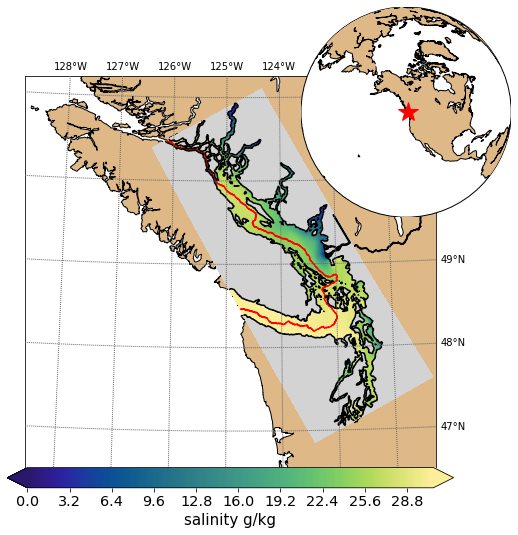

In [43]:
fact = 1.0
fig = plt.figure(figsize=(8*fact, 8*fact))
fs = 12
minh = 0
maxh = 31
halstep = 0.2

#domain plot - BR run summer average
ax1 = plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1) 

w_map = [-128.5, -121, 46.5, 51.2]
zorder=[0, 1, 7]
offset=[-40000, -15000]

lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

# Make projection
m = Basemap(projection='lcc', resolution='h',
            lon_0=lon_0, lat_0=lat_0,
            llcrnrlon=w_map[0], urcrnrlon=w_map[1],
            llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax1)

lons = np.floor([w_map[0], w_map[1] + 1])
lats = np.floor([w_map[2], w_map[3] + 1])

# Add features and labels
m.drawcoastlines(zorder=zorder[1])
m.fillcontinents(color='Burlywood', zorder=0)

m.drawparallels([47,48,49,50,51], labels=[0, 1, 0, 0], color='dimgray', zorder = 7)
m.drawmeridians([-129,-128,-127,-126, -125, -124, -123, -122, -121],\
                labels=[0, 1, 1, 0], color='dimgray', zorder = 7)
x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)  
tdat_p = BR3_sal_summer[0,:,:]
mesh = ax1.contourf(x, y, tdat_p, levels=np.arange(minh, maxh, halstep), \
                 cmap=cm.haline, extend = 'both') # extend='both', zorder=.2)

ax1.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
ax1.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)
plot_thalweg(ax1, x, y)

cbar = fig.colorbar(mesh, ax=ax1, orientation = 'horizontal',fraction=0.1, pad=0.00)
cbar.set_label(label='salinity g/kg', size=fs+3)
cbar.ax.tick_params(labelsize=fs+2.5)

#plot_annotations(ax1, m, annotations, zorder=7)

### Fraser
PNWrivers = loadmat('/ocean/rich/more/mmapbase/bcgeo/PNWrivers.mat')
cst = PNWrivers

bounds = [[0, 26000], [61500, 77000], [107500, 114000], [200000, 203000], [326000, 327000]]
for bound in bounds:
    i_old = 0
    for i in np.argwhere(np.isnan(cst['ncst'][bound[0]:bound[1], 1]))[:, 0]:
        x, y = m(cst['ncst'][bound[0]:bound[1], 0][i_old:i],
                 cst['ncst'][bound[0]:bound[1], 1][i_old:i])
        ax1.plot(x, y, 'k-')
        i_old = i + 1
            
ax2   = fig.add_axes([0.635, 0.635, 0.365, 0.365])


map = Basemap(projection='ortho', 
              lat_0=50, lon_0=-127)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='Burlywood',lake_color='white')
map.drawcoastlines()

x, y = map(-125, 50)

map.plot(x, y, marker='*',color='r', markersize = 20)


fig.savefig('Fig1_panela.png', dpi = 300)

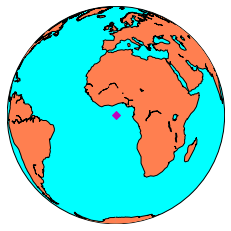

In [44]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap(projection='ortho', 
              lat_0=0, lon_0=0)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()

x, y = map(0, 0)

map.plot(x, y, marker='D',color='m')

plt.show()

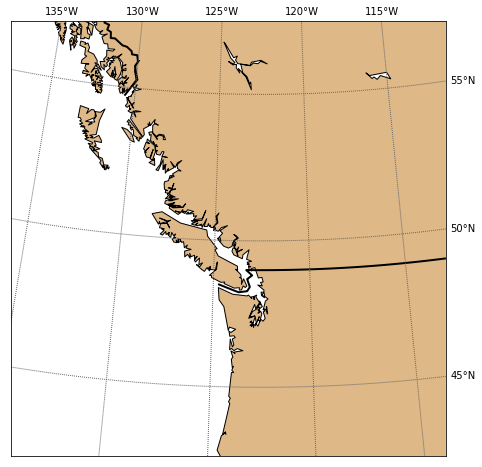

In [45]:


w_map = [-134, -111, 42, 57]

fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1) 
lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

# Make projection
m = Basemap(projection='lcc', resolution='l',
            lon_0=lon_0, lat_0=lat_0,
            llcrnrlon=w_map[0], urcrnrlon=w_map[1],
            llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax1)
zorder=[0, 1, 2]
offset=[None, None]
m.drawcoastlines(zorder=zorder[1])
m.fillcontinents(color='Burlywood', zorder=zorder[0])
m.drawmeridians([-135, -130, -125, -120, -115], labels=[0, 0, 1, 0], color='dimgray', yoffset=offset[1], zorder=zorder[2])
m.drawparallels([35,40,45,50,55,60], labels=[0, 1, 0, 0], color='dimgray', xoffset=offset[0], zorder=zorder[2])
m.drawcountries(linewidth = 2)


#m = plot_basemap2(ax1, w_map, zorder=[0, 1, 7]) #offset=[-30000, -15000]


### panel b

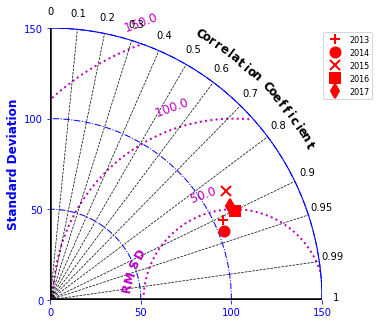

In [46]:
fig = plt.figure(figsize=(5.5*fact, 5*fact))

ax2 = plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1)
sm.taylor_diagram(sdevDIC,crmsdDIC,ccoefDIC, markerLabel = label,
                  markerLabelColor = 'r', 
                  markerColor = 'r', markerLegend = 'on', 
                  tickRMSangle = 110.0,
                  colRMS = 'm', styleRMS = ':', widthRMS = 2.0, 
                  titleRMS = 'on',  colSTD = 'b', styleSTD = '-.', 
                  widthSTD = 1.0, titleSTD = 'on', 
                  colCOR = 'k', styleCOR = '--', widthCOR = 0.7, 
                  titleCOR = 'on')
#ax2.text(0.03, 0.03, 'b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='bottom')
#ax2.set_title('DIC Taylor diagram',fontsize = fs+3, y=1.05)

fig.savefig('Fig1_panelb.png', dpi = 300)

### figs c and d - and colorbar

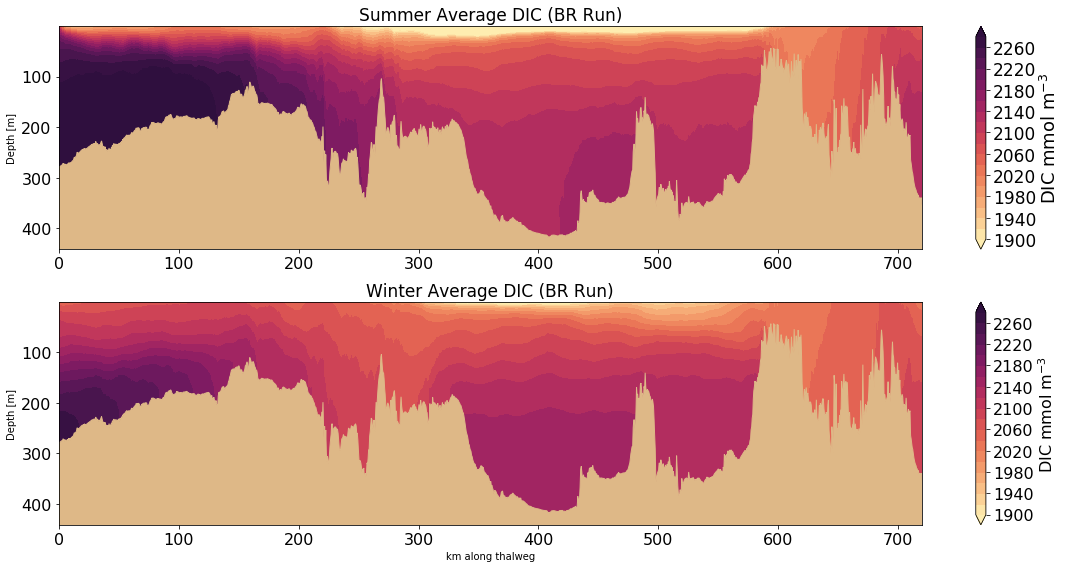

In [47]:
#set plot parameters
#scaling factor 
fact = 2
fs = 16
dicmin_twg = 1900
dicmax_twg = 2300
dicmin_surf = 0
dicmax_surf = 35
dicstep = 20
halstep = 0.1

fig = plt.figure(figsize=(8*fact, 4*fact))

#summertime mean
ax3 = plt.subplot2grid((2,4), (0,0), colspan=4, rowspan=1)
cbar = \
vis.contour_thalweg(ax3, BR3_DIC_summer, bathy, meshmask,\
                    np.arange(dicmin_twg, dicmax_twg, dicstep), cmap = cm.matter)
ax3.set_title('Summer Average DIC (BR Run)',fontsize = fs+1, y=1.0)
cbar.ax.tick_params(labelsize=fs+1) 
cbar.set_label('DIC mmol m$^{-3}$', fontsize = fs+2)
ax3.tick_params(axis='both', which='major', labelsize=fs)
#ax3.text(0.03, 0.03, 'c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='bottom')
ax3.tick_params(axis='both', which='major', labelsize=fs)
ax3.set_xlabel('')

##wintertime mean
ax4 = plt.subplot2grid((2,4), (1,0), colspan=4, rowspan=1)

cbar = \
vis.contour_thalweg(ax4, BR3_DIC_winter, bathy, meshmask,\
                    np.arange(dicmin_twg, dicmax_twg, dicstep), cmap = cm.matter)
ax4.set_title('Winter Average DIC (BR Run)',fontsize = fs+1, y=1.0)
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('DIC mmol m$^{-3}$', fontsize = fs)
ax4.tick_params(axis='both', which='major', labelsize=fs)
ax4.set_xlabel('km along thalweg')
#ax4.text(0.03, 0.03, 'd)', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='bottom')
ax4.tick_params(axis='both', which='major', labelsize=fs)

#colorbar - would need to refactor twg code
#ax5 = plt.subplot2grid((8,8), (4,7), colspan=1, rowspan = 4)
plt.tight_layout()
fig.savefig('Fig1_panelcd_colb.png', dpi = 300)

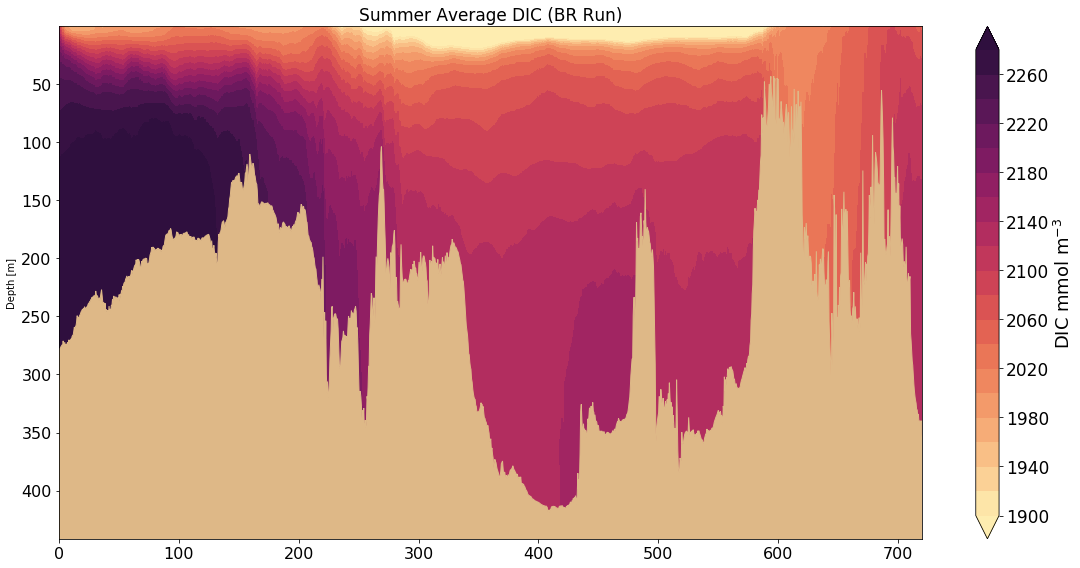

In [48]:
#set plot parameters
#scaling factor 
fact = 2
fs = 16
dicmin_twg = 1900
dicmax_twg = 2300
dicmin_surf = 0
dicmax_surf = 35
dicstep = 20
halstep = 0.1

fig = plt.figure(figsize=(8*fact, 4*fact))

#summertime mean
ax3 = plt.subplot2grid((1,4), (0,0), colspan=4, rowspan=1)
cbar = \
vis.contour_thalweg(ax3, BR3_DIC_summer, bathy, meshmask,\
                    np.arange(dicmin_twg, dicmax_twg, dicstep), cmap = cm.matter)
ax3.set_title('Summer Average DIC (BR Run)',fontsize = fs+1, y=1.0)
cbar.ax.tick_params(labelsize=fs+1) 
cbar.set_label('DIC mmol m$^{-3}$', fontsize = fs+2)
ax3.tick_params(axis='both', which='major', labelsize=fs)
#ax3.text(0.03, 0.03, 'c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='bottom')
ax3.tick_params(axis='both', which='major', labelsize=fs)
ax3.set_xlabel('')

#wintertime mean
# ax4 = plt.subplot2grid((2,4), (1,0), colspan=4, rowspan=1)

# cbar = \
# vis.contour_thalweg(ax4, BR3_DIC_winter, bathy, meshmask,\
#                     np.arange(dicmin_twg, dicmax_twg, dicstep), cmap = cm.matter)
# ax4.set_title('Winter Average DIC (BR Run)',fontsize = fs+1, y=1.0)
# cbar.ax.tick_params(labelsize=fs) 
# cbar.set_label('DIC mmol m$^{-3}$', fontsize = fs)
# ax4.tick_params(axis='both', which='major', labelsize=fs)
# ax4.set_xlabel('km along thalweg')
# #ax4.text(0.03, 0.03, 'd)', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='bottom')
# ax4.tick_params(axis='both', which='major', labelsize=fs)

# #colorbar - would need to refactor twg code
# #ax5 = plt.subplot2grid((8,8), (4,7), colspan=1, rowspan = 4)
plt.tight_layout()
fig.savefig('Fig1_panelcd_colb.png', dpi = 300)

#### CODE FOR CALCULATING SUMMER/WINTER DOMAIN AVG (commented out after running once)

In [49]:
# #winter1 - december

# start ='2015-12-01'
# end ='2015-12-31'

# start_run = arrow.get(start)
# end_run = arrow.get(end)

# arrow_array1 = []

# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array1.append(r)
# dayslen = len(arrow_array1)

# BR_winter1 = np.zeros([dayslen,40,898,398])

# for i in range(0,dayslen):

#     tdate = arrow_array1[i][0]
#     ymd = tdate.format('YYYYMMDD')

#     if i%20 == 0:
#         print(ymd)
#     tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/MAIN/BR_3rd_2015/ncs/SKOG*carp*'+ymd+'*.nc')
#     tnc = tstr[0]
#     tn = nc.Dataset(tnc)
#     t_dic = tn['dissolved_inorganic_carbon'][0,:,:,:]
#     BR_winter1[i,:,:,:] = t_dic

# #winter 2 is january-february
# start ='2015-01-01'
# end ='2015-02-28'

# start_run = arrow.get(start)
# end_run = arrow.get(end)
# arrow_array2 = []

# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array2.append(r)
# dayslen = len(arrow_array2)

# BR_winter2 = np.zeros([dayslen,40,898,398])

# for i in range(0,dayslen):

#     tdate = arrow_array2[i][0]
#     ymd = tdate.format('YYYYMMDD')

#     if i%20 == 0:
#         print(ymd)
#     tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/MAIN/BR_3rd_2015/ncs/SKOG*carp*'+ymd+'*.nc')
#     tnc = tstr[0]
#     tn = nc.Dataset(tnc)
#     t_dic = tn['dissolved_inorganic_carbon'][0,:,:,:]
#     BR_winter2[i,:,:,:] = t_dic


# BR_winter = np.concatenate((BR_winter1,BR_winter2),axis=0)
# print(np.shape(BR_winter))
# BR_winter_mean = np.nanmean(BR_winter,axis=0)
# pickle.dump(BR_winter_mean, open("./pkls/BR3_DIC_winter_mean.pkl", 'wb'))

# start ='2015-06-01'
# end ='2015-08-31'

# start_run = arrow.get(start)
# end_run = arrow.get(end)

# arrow_array1 = []

# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array1.append(r)
# dayslen = len(arrow_array1)

# BR_oma_summer1 = np.zeros([dayslen,40,898,398])

# for i in range(0,dayslen):

#     tdate = arrow_array1[i][0]
#     ymd = tdate.format('YYYYMMDD')

#     if i%10 == 0:
#         print(ymd)
#     tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/MAIN/BR_3rd_2015/ncs/SKOG*carp*'+ymd+'*.nc')
#     tnc = tstr[0]
#     tn = nc.Dataset(tnc)
#     t_dic = tn['dissolved_inorganic_carbon'][0,:,:,:]
#     BR_oma_summer1[i,:,:,:] = t_dic


# print(np.shape(BR_oma_summer1))
# BR_oma_summer_mean = np.nanmean(BR_oma_summer1,axis=0)
# pickle.dump(BR_oma_summer_mean, open("./pkls/BR3_DIC_summer_mean.pkl", 'wb'))